In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# creates engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflects an existing database into a new model
Base = automap_base()

# reflects the tables
Base.prepare(autoload_with = engine)

In [6]:
# Views all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Saves references to each table
station = Base.classes.station

measurement = Base.classes.measurement



In [29]:
from sqlalchemy import inspect
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Creates the session (link) from Python to the DB

session = Session(engine)

# Exploratory Precipitation Analysis

In [86]:
# Finds the most recent date in the data set.

dates = session.query(func.max(measurement.date)).first()
    
for date in dates:
    recent_date = date
    print(date)


2017-08-23


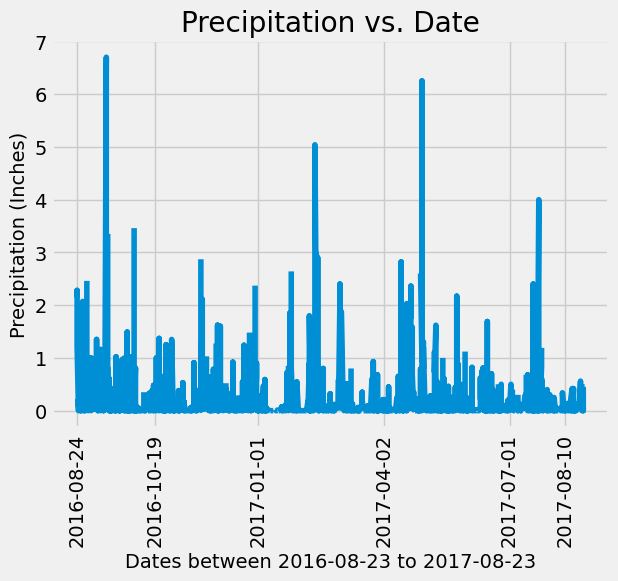

In [87]:
# Designs a query to retrieve the last 12 months of precipitation data and plot the results. 

dates = []
precipitation = []
 

# Calculates the date one year from the last date in data set.

recent_date = dt.datetime.fromisoformat(recent_date)
one_year_date = recent_date - dt.timedelta(days = 365)

# Performs a query to retrieve the date and precipitation scores for year-span

filter1 =  session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_date)


filter2 = filter1.filter(measurement.date <= recent_date)


# Saves the query results as a Pandas DataFrame

for value in filter2:
    dates.append(value[0])
    precipitation.append(value[1])

    
precipitation_date_dataframe = pd.DataFrame({"dates": dates,
                                             "precipitation": precipitation})

# Sorts the dataframe by date

precipitation_date_dataframe = precipitation_date_dataframe.sort_values(by = ['dates'])

# Plots the data


plt.plot(precipitation_date_dataframe['dates'], precipitation_date_dataframe['precipitation'])
plt.xlabel('Dates between 2016-08-23 to 2017-08-23')
plt.xticks(['2016-08-24','2016-10-19','2017-01-01','2017-04-02','2017-07-01','2017-08-10'], rotation = 90)
plt.title('Precipitation vs. Date') 
plt.ylabel('Precipitation (Inches)')
plt.show()/api/v1.0/precipitation




In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [61]:
# Calculates the summary statistics of the precipitation data
summary = precipitation_date_dataframe['precipitation'].describe()
summary2 = summary.reset_index()
summary2


,index,precipitation
0,count,2015.000000
1,mean,0.176462
2,std,0.460288
3,min,0.000000
4,25%,0.000000
5,50%,0.020000
6,75%,0.130000
7,max,6.700000


# Exploratory Station Analysis

In [92]:
# Provides all columns and data types in 'station'

from sqlalchemy import inspect
inspector = inspect(engine)
columns = inspector.get_columns('station')

for column in columns:
    print(column['name'], column['type'])


    

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [91]:
# Designs a query to calculate the total number of stations in the dataset

    
station_count = session.query(station.station).count()

print(station_count)
    



9


In [103]:
# Designs a query to find the most active stations in descending order


active_station = session.query(measurement.station, func.count(measurement.station))

active_station = active_station.group_by(measurement.station)

active_station = active_station.order_by(func.count(measurement.station).desc())

for station in active_station:
    print(station)




('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [109]:
most_active_station_row = active_station.order_by(func.count(measurement.station).desc()).first()

most_active_station = most_active_station_row[0]

most_active_station

'USC00519281'

In [131]:
# Calculates the lowest, highest, and average temperature using the most active station id from the previous query

active_station_temp = session.query(func.min(measurement.tobs), func.max(measurement.tobs), 
                                    func.avg(measurement.tobs))

active_station_temp = active_station_temp.filter(measurement.station == most_active_station).all()

active_station_temp


[(54.0, 85.0, 71.66378066378067)]

In [161]:
# Finds the final recorded date for the most active station

all_temp = session.query(measurement.tobs, measurement.date)

all_temp = all_temp.filter(measurement.station == most_active_station)

all_temp = all_temp.order_by(measurement.date.desc()).first()

final_date = all_temp[1]



In [162]:
# Converts the final date into a datetime format

final_date = dt.datetime.fromisoformat(final_date)


# Finds the date for the year prior and converts it to string

first_date = final_date - dt.timedelta(days = 365)

first_date = first_date.strftime("%Y-%m-%d")



In [163]:
# Queries the last 12 months of temperature observation data for this station 


temp_12_months = session.query(measurement.tobs).filter(measurement.station == most_active_station)

temp_12_months = temp_12_months.filter(measurement.date >= first_date).all()


# Puts all the temperatures of the most active station into a list

temp_list = []

for temp in temp_12_months:
    temp_list.append(temp[0])    

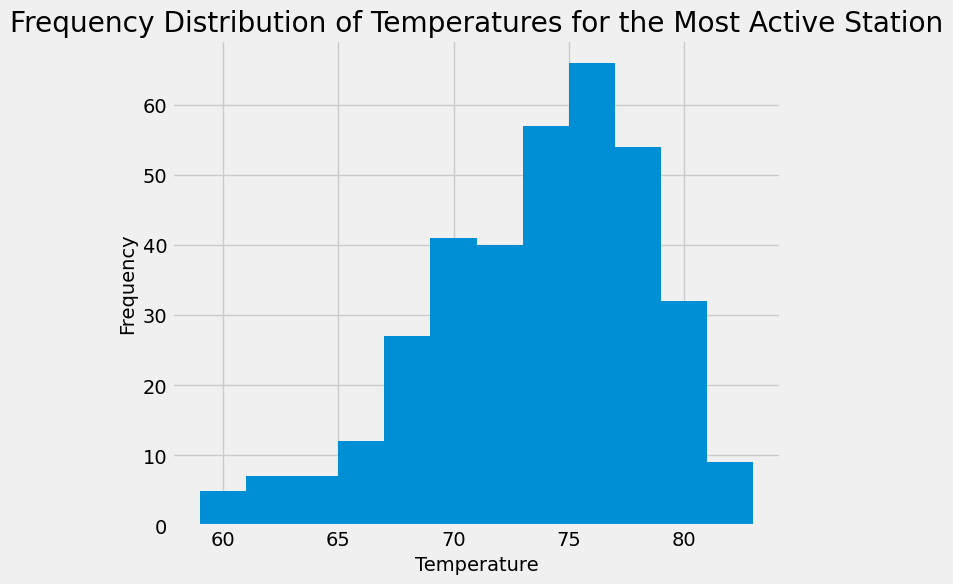

In [166]:
# Plots histogram of the queried temperatures 

plt.figure(figsize= (7, 6))
plt.hist(temp_list, bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Temperatures for the Most Active Station")
plt.show()


# Close Session

In [167]:
# Closes Session

session.close()